<a href="https://www.kaggle.com/code/vidhikishorwaghela/image-inpainting-cifar10?scriptVersionId=141424839" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import cv2

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
#setting the random seed for reproducibility:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
#Loading the CIFAR10 dataset:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

170498071/170498071 [==============================] - 6s 0us/step


In [4]:
#Defining the parameters:
input_shape = (32, 32, 3)
mask_height, mask_width = 10, 10
mask_value = 0.5

In [5]:
# Create masked images
def create_masked_images(images, mask_height, mask_width, mask_value):
    masked_images = np.copy(images)
    mask = np.ones((mask_height, mask_width, 3)) * mask_value
    for i in range(len(masked_images)):
        x = np.random.randint(0, input_shape[0] - mask_height)
        y = np.random.randint(0, input_shape[1] - mask_width)
        masked_images[i, x:x+mask_height, y:y+mask_width, :] = mask
    return masked_images

x_train_masked = create_masked_images(x_train, mask_height, mask_width, mask_value)
x_test_masked = create_masked_images(x_test, mask_height, mask_width, mask_value)


In [6]:
def create_autoencoder():
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),

        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(3, (3, 3), activation='linear', padding='same')
    ])
    return model

autoencoder = create_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse') 


In [7]:
# Train the autoencoder
autoencoder.fit(x_train_masked, x_train, epochs=100, batch_size=128, validation_split=0.1)


Epoch 1/100
352/352 [==============================] - 34s 56ms/step - loss: 24.4472 - val_loss: 0.0620
Epoch 2/100
352/352 [==============================] - 18s 53ms/step - loss: 0.0626 - val_loss: 0.0614
Epoch 3/100
352/352 [==============================] - 18s 52ms/step - loss: 0.0416 - val_loss: 0.0215
Epoch 4/100
352/352 [==============================] - 18s 50ms/step - loss: 0.0192 - val_loss: 0.0156
Epoch 5/100
352/352 [==============================] - 18s 50ms/step - loss: 0.0145 - val_loss: 0.0133
Epoch 6/100
352/352 [==============================] - 18s 50ms/step - loss: 0.0124 - val_loss: 0.0114
Epoch 7/100
352/352 [==============================] - 18s 50ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 8/100
352/352 [==============================] - 18s 50ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 9/100
352/352 [==============================] - 18s 51ms/step - loss: 0.0100 - val_loss: 0.0105
Epoch 10/100
352/352 [==============================] - 18s 50ms/step - 

313/313 [==============================] - 3s 7ms/step


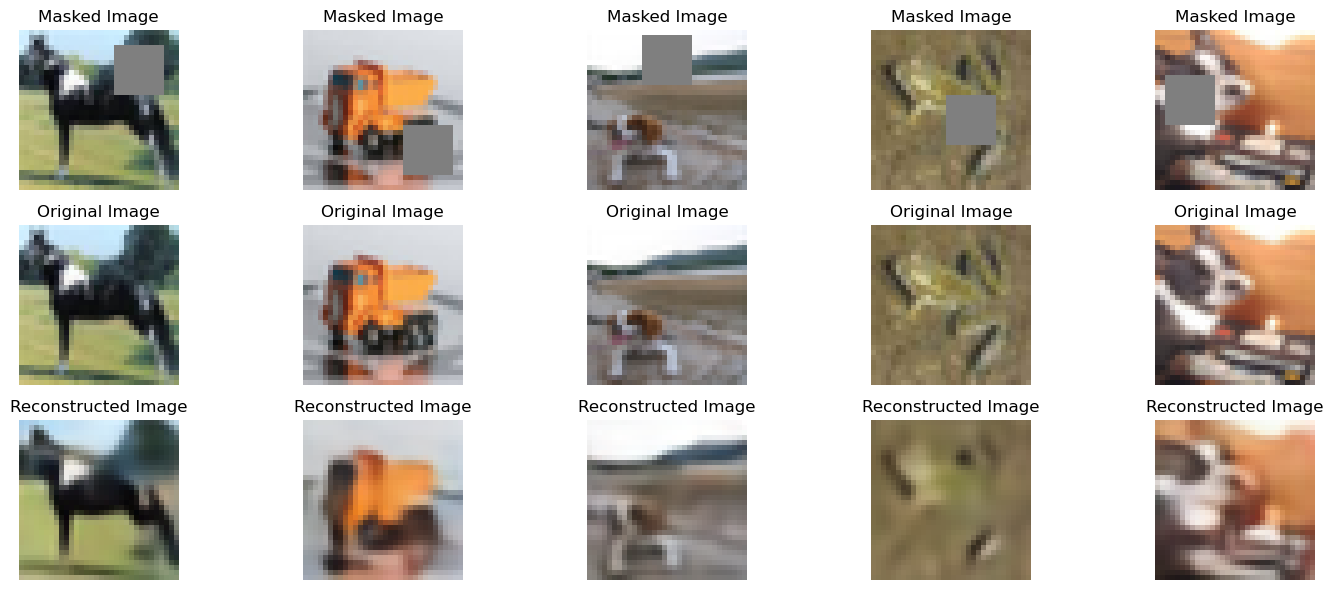

Test MSE: 0.0044014333


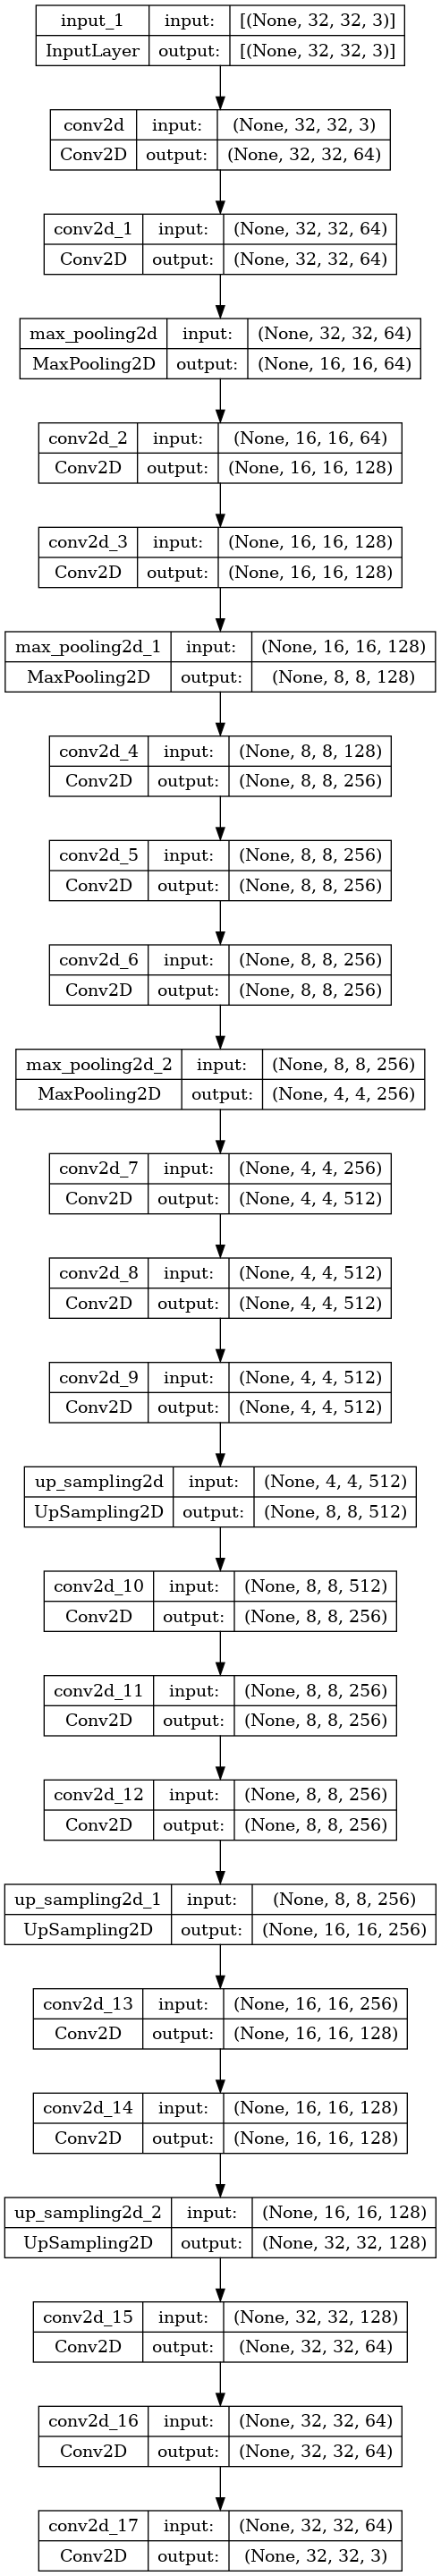

In [8]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set and visualize results
def evaluate_autoencoder(model, x_test, x_test_masked):
    x_test_predicted = model.predict(x_test_masked)

    # Compute evaluation metrics
    mse = np.mean((x_test_predicted - x_test) ** 2)

    # Visualize some examples
    num_examples = 5
    np.random.seed(0)
    random_indices = np.random.randint(0, len(x_test), num_examples)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(random_indices):
        plt.subplot(3, num_examples, i + 1)
        plt.imshow(x_test_masked[idx])
        plt.title("Masked Image")
        plt.axis("off")

        plt.subplot(3, num_examples, num_examples + i + 1)
        plt.imshow(x_test[idx])
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(3, num_examples, 2 * num_examples + i + 1)
        plt.imshow(x_test_predicted[idx])
        plt.title("Reconstructed Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    return mse

mse = evaluate_autoencoder(autoencoder, x_test, x_test_masked)
print("Test MSE:", mse)

# Plot the model architecture
plot_model(autoencoder, to_file='autoencoder_model.png', show_shapes=True)
